# RNAseq differential expression analysis of TEs in Drosophila melanogaster (DmGoth lineage)

## Alignment to TE Consensus sequences

TE consensus sequences are contained in D_mel_transposon_sequence_set.fa (downloaded from https://github.com/bergmanlab/transposons/ )
By aligning reads to these sequences, we can identify which TEs are expressed and get countings.

Commands : 
```
~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC29.fastq.gz | samtools sort -o FC29.against_consensus.bam

~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC30.fastq.gz | samtools sort -o FC30.against_consensus.bam
```
We get two bam files as a result (FC29 : 5.2Go, FC30 : 1.8Go )

## Some informations on our reads...

Here's an example of what's in D_mel_transposon_sequence_set.fa : 
```
>1731#LTR/Copia
TGTTGAATATAGGCAATGCCCACATGTGTGTTGAATATAGGCAATTTCCACATGTGCATA
TGTAATTTTGTATGAGAACATACATACATACACATGAACTGTATGTATGTATATATATTA
```

And here's the beginning of the BAM we get by aligning our reads to the TEs consensus sequences : 
```
e1bae963-07b0-44fa-8a67-ae90f86c4ba0    2064    Tc3#DNA/Tc1-Mariner     331     38      710H32M5D19M2D8M1D5M1D18M1D4M1D124M1384H        *       0
       0       GGTTTTACGCTTCTAACTTGACTTCTTGTTTGTTAAATCTCGAAAGTTAAATTCTTTTGATTCTAAATATAAATTATCTTTTTAATTTTTTCTCAAATGGTCCGCGAAAAGTCTTTATCCGATTTTGAAAAAGGTCAAATCAAAGGCTATATTGAATCTGGTTTAAAACACTGTGTAATAGCCAAGAAAATCGGTTGAAGTCAAAACGTT      53/a:/-$7)4/($,%"/$#''-2#"$-5'"''$#'&$%'$"+2%4)*+/)(:?-L/$)2(('#/7+(,$+.#&%(%#&'0-%+(*16995,0.*?;3;9;+*+*/(--)&"%()%8<89210OG?*)NPMPKGC)6>:>*/H5?;-%3/2B4.DLL./A8<:*'A>-"1%#)0255A<*5H2.N(JQ@=J+?@A+-6L7K4)KT1=@WR      NM:i:35 ms:i:115        AS:i:115        nn:i:0  tp:A:P  cm:i:9  s1:i:64 s2:i:0  de:f:0.1389     SA:Z:McClintock#LTR/Gypsy,592,+,1229S153M2I920S,60,11;  rl:i:0
```

We want to count how many reads are aligned on each TEs sequences BUT, we need to remind ourselves that a read can be aligned to several features, then, which one should we count ?

Let's get a look at the alignQC report for FC30.bam
```
alignqc analyze FC30.sorted.bam -g D_mel_transposon_sequence_set.fa -o FC30.consensus.report/FC30.consensus.alignqc.xhtml
```

Well, that didn't work. Seems like a Windows return carriage error ? Maybe this could help :
```
tr -d '\r' < D_mel_transposon_sequence_set.fa > D_mel_transposon_sequence_set.fixed.fa
```
NGS crashed in the meantime, and it did not help : we still got the same error message : 
```
  File "/data/home/ecumunel/.local/lib/python2.7/site-packages/seqtools/errors.py", line 813, in get_context_target_errors
    r[t][tafter]['-']['total'] += 0.5
KeyError: 'Y'
```

Another thing to take into account :
They are primary, secondary, supplementary and unmapped reads. Which one should we count and not count ?
I guess we should discard supplementary alignments and unmapped reads.
Let's check manually how many primary and secondary reads we got.


#### Example case of a supplementary read : e1bae963-07b0-44fa-8a67-ae90f86c4ba0

This read generate two alignments : one primary (in McClintock#LTR/Gypsy) and one supplementary (in Tc3#DNA/Tc1-Mariner). The alignment score is better in the primary. In both case, the alignment covers a very small part of the consensus sequence...



In [2]:
import pysam
FC29_bamfile = "data/consensus/bam/FC29.against_consensus.bam"
FC30_bamfile = "data/consensus/bam/FC30.against_consensus.bam"


In [5]:
unmapped = 0
supp = 0
secondary = 0
primary = 0
with pysam.AlignmentFile(FC29_bamfile, 'rb') as bam1:
    for ali in bam1:
        if ali.is_supplementary:
            supp += 1
        elif ali.is_unmapped:
            unmapped += 1
        elif ali.is_secondary:
            secondary += 1
        else:
            primary += 1
print(supp, unmapped, secondary, primary)

424 2918185 953 7369


So we've got around 3 millions unmapped reads, 400 supplementary, 1000 secondary and 7369 primary alignments. This seems very low, but considering we only aligned against TE consensus sequences, which is like 2% of the transcriptome, it's actually not so bad. And FC29 is the smallest dataset.

A more helpful number should be the number of single mapped read (read that mapped to only one feature)  
TODO : fix the following script.

In [28]:
single_mapped_reads = 0
FC29_alignments = pysam.AlignmentFile(FC29_bamfile, 'rb')
read_index = pysam.IndexedReads(FC29_alignments)
read_index.build()

In [1]:
# THIS IS NOT WORKING : (2924314)

single_mapped = 0
with pysam.AlignmentFile(FC29_bamfile, 'rb') as bam1:
    for ali in bam1:
        if not ali.is_secondary and not ali.is_unmapped and len(list(read_index.find(ali.query_name))) == 1:
            single_mapped += 1
print(single_mapped)


NameError: name 'pysam' is not defined



## Getting the expression level of each TE

We can extrapolate the expression level of a said TE from the number of reads that mapped on its consensus sequence.
A table representing the counting of each feature between female and male. A ratio would be preferable as we have fewer reads from female to work with. Only primary read are being counted.

Let's gather our data into a python dict first : 

In [3]:
def get_countings_from_bam(bamfile):
    counting_dict = dict()
    alignment_file = pysam.AlignmentFile(bamfile, 'rb')
    for ali in alignment_file:
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            if not ali.reference_name in counting_dict :
                counting_dict[ali.reference_name] = 0
            counting_dict[ali.reference_name] += 1
    return counting_dict

consensus_counting_female_dict = get_countings_from_bam(FC29_bamfile)
consensus_counting_male_dict = get_countings_from_bam(FC30_bamfile)

full_consensus_counting_dict = dict()
for feature in consensus_counting_female_dict:
    if not feature in consensus_counting_male_dict :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], 0]
    else :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], consensus_counting_male_dict[feature]]

for feature in consensus_counting_male_dict:
    if not feature in consensus_counting_female_dict :
        full_consensus_counting_dict[feature] = [0, consensus_counting_male_dict[feature]]

print(full_consensus_counting_dict)

{'Tc3#DNA/Tc1-Mariner': [4, 0], '1731#LTR/Copia': [39, 0], 'mdg3#LTR/Gypsy': [6, 0], 'mdg1#LTR/Gypsy': [11, 4], 'gypsy#LTR/Gypsy': [23, 1], 'copia#LTR/Copia': [245, 131], 'Bari1#DNA/Tc1-Mariner': [1, 1], 'jockey#LINE/Jockey': [39, 7], '17.6#LTR/Gypsy': [96, 4], 'R1A1-element#LINE/R1': [1, 2], 'Cr1a#LINE/CR1': [34, 6], 'TAHRE#LINE/Jockey': [135, 4], 'gypsy8#LTR/Gypsy': [19, 0], 'gypsy7#LTR/Gypsy': [1, 1], 'G5A#LINE/Jockey': [217, 15], 'invader5#LTR/Gypsy': [1, 1], 'ZAM#LTR/Gypsy': [37, 0], 'FB#DNA/Tc1-Mariner': [19, 15], 'G4#LINE/Jockey': [99, 0], 'invader4#LTR/Gypsy': [8, 1], 'Max-element#LTR/Bel-Pao': [75, 14], '3S18#LTR/Bel-Pao': [32, 0], 'frogger#LTR/Copia': [43, 0], 'Dm88#LTR/Copia': [13, 2], 'GATE#LTR/Bel-Pao': [23, 0], 'Doc#LINE/Jockey': [133, 6], 'gypsy10#LTR/Gypsy': [690, 2], 'invader1#LTR/Gypsy': [92, 4], 'Tom1#LTR/Gypsy': [135, 246], 'HB#DNA/Tc1-Mariner': [64, 3], 'flea#LTR/Gypsy': [50, 7], 'BS3#LINE/Jockey': [29, 0], 'NOF#DNA/MuDR': [4, 0], 'Stalker2#LTR/Gypsy': [8, 29], 'ho

Let's translate those numbers into ratio.

In [6]:
total_count_female = 0
total_count_male = 0
for count_female, count_male in full_consensus_counting_dict.values():
    total_count_female += count_female
    total_count_male += count_male

full_consensus_ratio_dict = dict()
for feature, counting in full_consensus_counting_dict.items():
    female_ratio = 0 if counting[0] == 0 else counting[0]/total_count_female
    male_ratio = 0 if counting[1] == 0 else counting[1]/total_count_male
    full_consensus_ratio_dict[feature] = [female_ratio, male_ratio]

print(full_consensus_ratio_dict)

{'Tc3#DNA/Tc1-Mariner': [0.000542814493146967, 0], '1731#LTR/Copia': [0.005292441308182928, 0], 'mdg3#LTR/Gypsy': [0.0008142217397204505, 0], 'mdg1#LTR/Gypsy': [0.0014927398561541594, 0.0032388663967611335], 'gypsy#LTR/Gypsy': [0.0031211833355950605, 0.0008097165991902834], 'copia#LTR/Copia': [0.03324738770525173, 0.10607287449392712], 'Bari1#DNA/Tc1-Mariner': [0.00013570362328674176, 0.0008097165991902834], 'jockey#LINE/Jockey': [0.005292441308182928, 0.005668016194331984], '17.6#LTR/Gypsy': [0.013027547835527209, 0.0032388663967611335], 'R1A1-element#LINE/R1': [0.00013570362328674176, 0.0016194331983805667], 'Cr1a#LINE/CR1': [0.00461392319174922, 0.004858299595141701], 'TAHRE#LINE/Jockey': [0.018319989143710136, 0.0032388663967611335], 'gypsy8#LTR/Gypsy': [0.002578368842448093, 0], 'gypsy7#LTR/Gypsy': [0.00013570362328674176, 0.0008097165991902834], 'G5A#LINE/Jockey': [0.02944768625322296, 0.012145748987854251], 'invader5#LTR/Gypsy': [0.00013570362328674176, 0.0008097165991902834], '

In [20]:
print('{:<8}\t{:<15}\t{:<10}'.format('Feature','Female','Male'))
for k, v in full_consensus_ratio_dict.items():
    female_ratio, male_ratio = v

    print("{:<8}\t{:<15}\t{:<10}".format(k, female_ratio, male_ratio))
print(test)

Feature 	Female         	Male      
Tc3#DNA/Tc1-Mariner	0.000542814493146967	0         
1731#LTR/Copia	0.005292441308182928	0         
mdg3#LTR/Gypsy	0.0008142217397204505	0         
mdg1#LTR/Gypsy	0.0014927398561541594	0.0032388663967611335
gypsy#LTR/Gypsy	0.0031211833355950605	0.0008097165991902834
copia#LTR/Copia	0.03324738770525173	0.10607287449392712
Bari1#DNA/Tc1-Mariner	0.00013570362328674176	0.0008097165991902834
jockey#LINE/Jockey	0.005292441308182928	0.005668016194331984
17.6#LTR/Gypsy	0.013027547835527209	0.0032388663967611335
R1A1-element#LINE/R1	0.00013570362328674176	0.0016194331983805667
Cr1a#LINE/CR1	0.00461392319174922	0.004858299595141701
TAHRE#LINE/Jockey	0.018319989143710136	0.0032388663967611335
gypsy8#LTR/Gypsy	0.002578368842448093	0         
gypsy7#LTR/Gypsy	0.00013570362328674176	0.0008097165991902834
G5A#LINE/Jockey	0.02944768625322296	0.012145748987854251
invader5#LTR/Gypsy	0.00013570362328674176	0.0008097165991902834
ZAM#LTR/Gypsy	0.005021034061609445	0      

#### Let's plot this for readibility

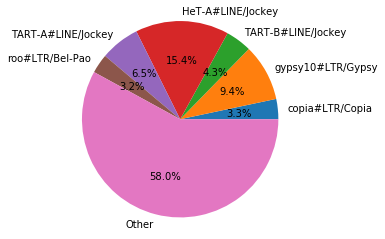

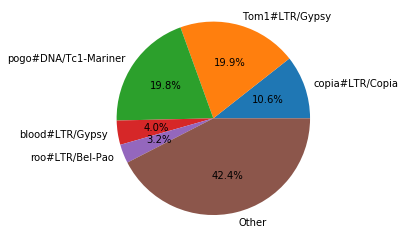

In [49]:
import matplotlib.pyplot as plt

## FEMALE PIE CHART

def get_simple_pie_chart_from_consensus(consensus_counting_dict, min_ratio_threshold = 0.03):
    total_count = sum(consensus_counting_dict.values())
    other_count = 0
    label_list = []
    count_list = []
    for feature, count in consensus_counting_dict.items():
        ratio = 0 if count == 0 else count/total_count
        # ratio = 0 if count == 0 else count/total_count_female
        if ratio >= min_ratio_threshold:
            label_list.append(feature)
            count_list.append(count)
        else:
            other_count += count
    label_list.append('Other')
    count_list.append(other_count)

    fig1, ax1 = plt.subplots()
    ax1.pie(count_list, labels=label_list, autopct='%1.1f%%')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

get_simple_pie_chart_from_consensus(consensus_counting_female_dict)
get_simple_pie_chart_from_consensus(consensus_counting_male_dict)